In [1]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
real_data = "CrossMatch"
altered_data = "AMSL_SynFP_SGR_v1/crossmatch_andrey_512_seeds1-50000"

Sokoto Coventry Fingerprint Dataset (SOCOFing) is a biometric fingerprint database designed for academic research purposes. SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut. For a complete formal description and usage policy please refer to the following paper: https://arxiv.org/abs/1807.10609

In [2]:
data = []
labels = []

# load the real data and their labels
photos_names = os.listdir(real_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
    labels.append(0)

# load the altered data and their labels
photos_names = os.listdir(altered_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(altered_data, name) ,cv.IMREAD_GRAYSCALE))
    labels.append(1)

In [3]:
x = 96
y = 103

In [4]:
# resizeing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv.resize(image ,(x,y))
    
data = np.stack(data).reshape(-1 ,y ,x ,1)
labels = np.stack(labels).reshape(-1 ,1)

In [5]:
train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

In [6]:
# print the shape of the data for each image
i = 0
for image in train_data:
    if image.shape != (y, x, 1):
        i += 1
print('images without the correct shape: ', i)

images without the correct shape:  0


[1]


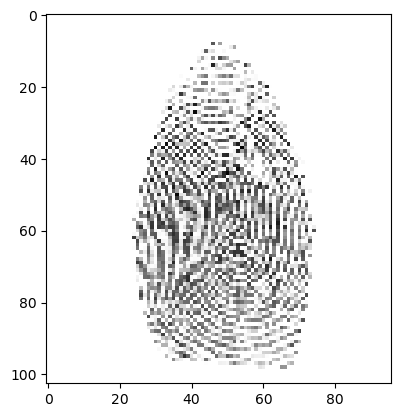

In [23]:
# visualization of 1 image from train data
import matplotlib.pyplot as plt
print(train_labels[1])
plt.imshow(train_data[1], cmap='gray')
plt.show()

In [8]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

In [9]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense

# passar pra 3 canais
# incluir uma camada que faça a classificacao
# flatten
# densa
# classificacao

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [10]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1009/1009 [==============================] - 44s 37ms/step - loss: 0.3100 - binary_accuracy: 0.9910 - val_loss: 0.0405 - val_binary_accuracy: 0.9964
Epoch 2/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0285 - binary_accuracy: 0.9967 - val_loss: 0.0260 - val_binary_accuracy: 0.9922
Epoch 3/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0171 - binary_accuracy: 0.9975 - val_loss: 0.0146 - val_binary_accuracy: 0.9979
Epoch 4/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0058 - binary_accuracy: 0.9986 - val_loss: 0.0194 - val_binary_accuracy: 0.9978
Epoch 5/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0046 - binary_accuracy: 0.9990 - val_loss: 0.0121 - val_binary_accuracy: 0.9985
Epoch 6/10
1009/1009 [==============================] - 37s 36ms/step - loss: 0.0097 - binary_accuracy: 0.9984 - val_loss: 0.0116 - val_binary_accuracy: 0.9975
Epoch 7/10
1009/1009 [==================

In [12]:
y_pred = model.predict(test_data_3)

316/316 [==============================] - 8s 25ms/step


In [13]:
test_labels_tensor

<tf.Tensor: shape=(10082, 1), dtype=int16, numpy=
array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int16)>

In [14]:
y_pred

array([[0.99997735],
       [1.        ],
       [0.9994523 ],
       ...,
       [0.99963784],
       [0.99999774],
       [0.9999871 ]], dtype=float32)

In [17]:
a= np.rint(y_pred)

unique, counts = np.unique(a, return_counts=True)

dict(zip(unique, counts))

{0.0: 50, 1.0: 10032}

In [18]:
# calculate the balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred)))

0.8355664833157008


In [19]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_labels_tensor, np.rint(y_pred))
print(conf_mat)

[[   49    24]
 [    1 10008]]


In [20]:
conf_mat = confusion_matrix(test_labels_tensor, np.rint(y_pred), normalize='true')
print(conf_mat)

[[6.71232877e-01 3.28767123e-01]
 [9.99100809e-05 9.99900090e-01]]


In [40]:
confusion_matrix(test_labels_tensor, np.rint(y_pred)).ravel()

array([ 689,  533,  416, 9416], dtype=int64)